# Detectors

Review of all the detectors implemented in ByoTrack. For more details, have a look at the documentation or implementation of each detector.

3D visualization of detections is not mature in ByoTrack and we advise that you save the segmentation mask to a 3D tiff and visualize them with Fiji/Icy.
___________________________________________________

1. **Wavelet Detector** (Wavelet decomposition + noise filtering)
2. **StarDist** (Unet + StarConvex prior)

In [1]:
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

import byotrack
import byotrack.example_data
import byotrack.visualize

## Load a video

In [2]:
# Open an example video
video = byotrack.example_data.hydra_neurons()

# Or provide a path to one of your video
# video = byotrack.Video("path/to/video.ext")

# Or load manually a video as a numpy array
# video = np.random.randn(50, 500, 500, 3)  # T, H, W, C

In [3]:
TEST = True  # Set to False to analyze a whole video

if TEST:
    video = video[:50]  # Temporal slicing to analyze only the first 50 frames

In [4]:
# A transform can be added to normalize and aggregate channels

transform_config = byotrack.VideoTransformConfig(
    aggregate=True, normalize=True, q_min=0.01, q_max=0.999, smooth_clip=1.0
)
video.set_transform(transform_config)

# Show the min max value used to clip and normalize
print(video._normalizer.mini, video._normalizer.maxi)

[0.] [248.]


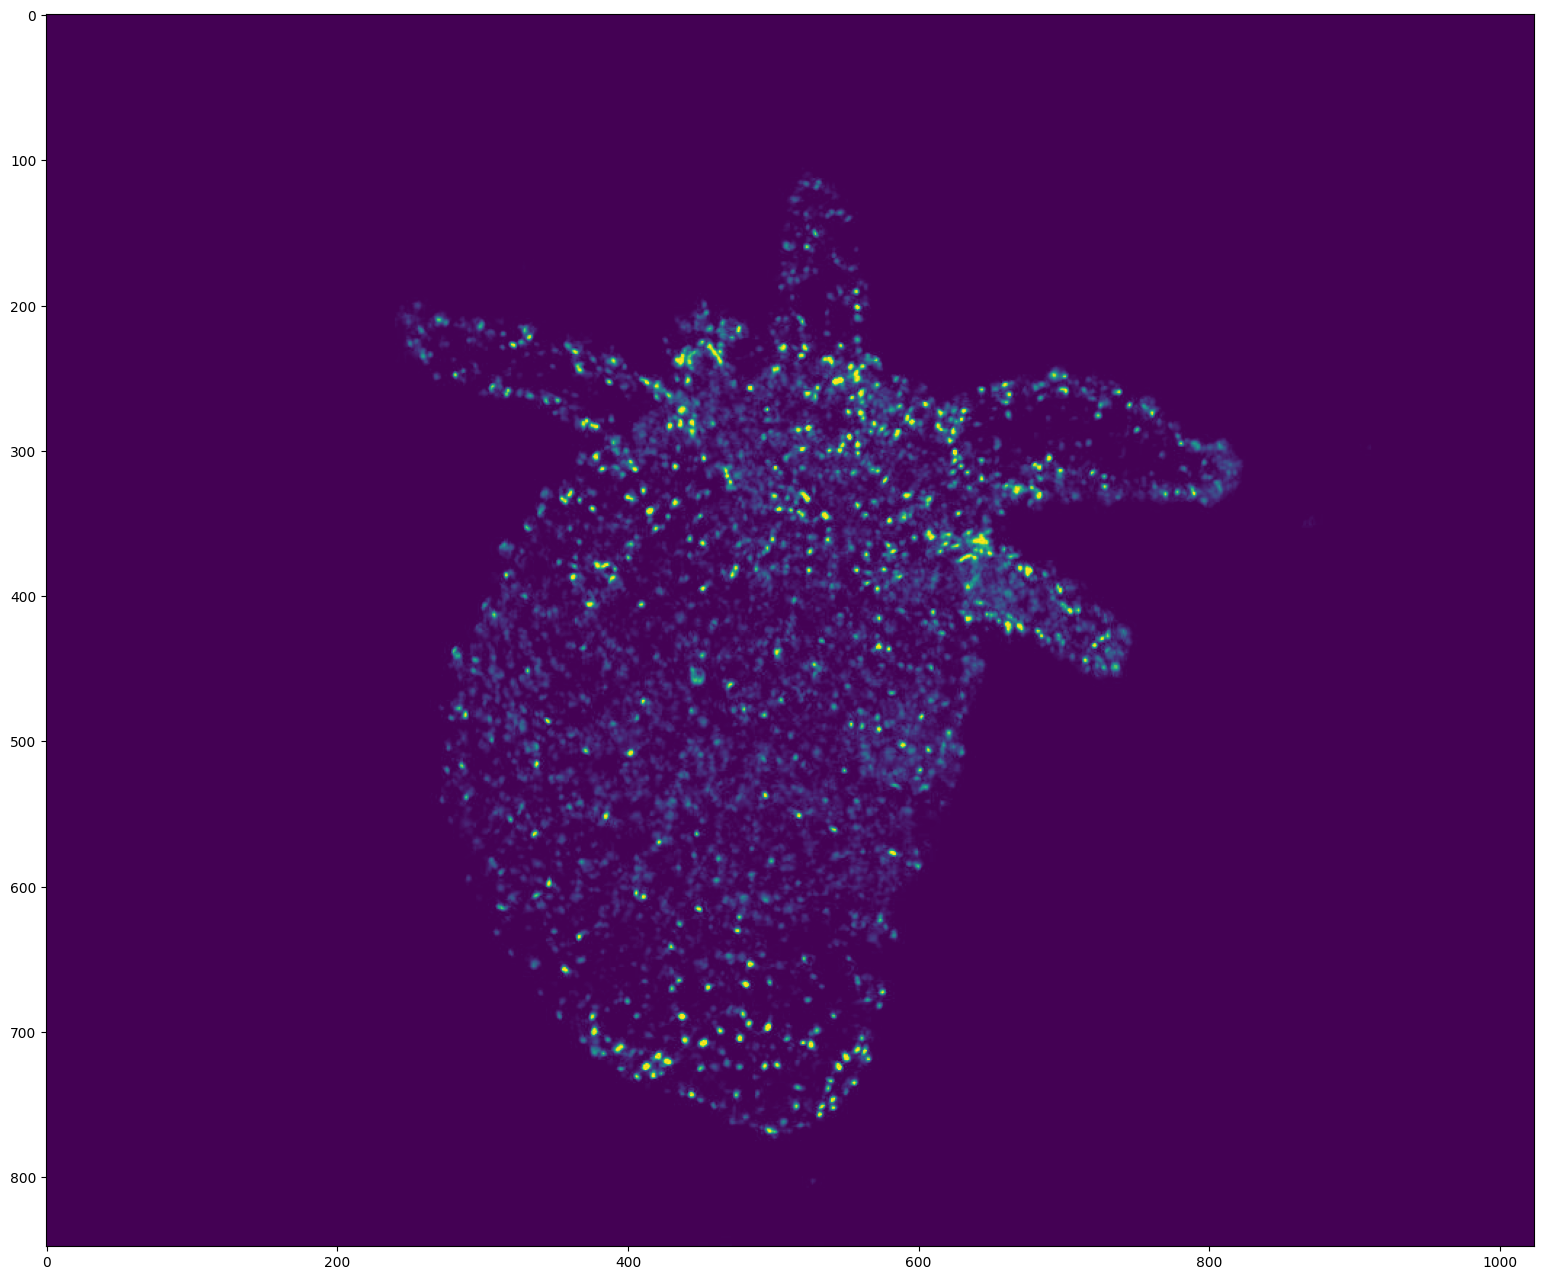

In [5]:
# Display the first frame

frame = video[0]
if  video.ndim == 5:  # (T, D, H, W, C) (3D video)
    frame = frame[frame.shape[0] // 2]  # Show the frame in the middle of the stack

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(frame)
plt.show()

## WaveletDetector

In [6]:
from byotrack.implementation.detector.wavelet import WaveletDetector

In [7]:
# See the Detector documentation

WaveletDetector?

In [8]:
# Create the detector object with its hyper parameters. 
# The most important ones being the scale (size of the spots) and k the threshold noise

detector = WaveletDetector(scale=1, k=3.0, min_area=5.0, batch_size=20, device=torch.device("cpu"))

In [9]:
# Set the hyperparameters manually on the video (Only works with 2D videos)
# Use w/x to move backward/forward in the video
# Use c/v to update k (noise threshold)
# Use b/n to update the scale (expected size of the spots)
# You can also use the min_area to filter more or less spots given their area

K_SPEED = 0.01
scale = detector.scale

i = 0

while True:
    frame = video[i]

    # Run detection on a single frame using detect
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255
    
    image = np.concatenate((frame, np.zeros_like(frame), mask[..., None]), axis=-1)

    # Display the resulting frame
    cv2.imshow('Frame', image)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - scale={scale}, k={detector.k} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)
        
    if key == ord("c"):
        detector.k = detector.k * (1 - K_SPEED)

    if key == ord("v"):
        detector.k = detector.k * (1 + K_SPEED)
        
    if key == ord("b"):
        scale = max(0, scale - 1)
        detector = WaveletDetector(scale, detector.k, detector.min_area, detector.device)
        
    
    if key == ord("n"):
        scale = min(4, scale + 1)
        detector = WaveletDetector(scale, detector.k, detector.min_area, detector.device)


cv2.destroyAllWindows()

In [10]:
# Run the detection process on the current video

detections_sequence = detector.run(video)

Detections (Wavelet):   0%|          | 0/50 [00:00<?, ?it/s]

## StarDist 

In [11]:
from byotrack.implementation.detector.stardist import StarDistDetector

2024-07-04 15:21:32.589353: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-04 15:21:32.625129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-04 15:21:33.046702: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# See the Detector documentation

StarDistDetector?

In [13]:
# Use your active stardist model, or load a trained own or pretrained own from the official implementation:
# Hyperparameters are usually set during the training phase (nms_treshold and prob_threshold)
# They can be changed manually (See next cells)

# From a current model:
# detector = StarDistDetector(stardist_model, batch_size=1)

# Load a pretrained model with a valid id
# detector = StarDistDetector.from_pretrained("2D_versatile_fluo", batch_size=1)

# Create the detector object from a trained model. Note that the training should be done with
# the official implementation (https://github.com/stardist/stardist).
train_dir = "path/to/trained/model/"

detector = StarDistDetector.from_trained(train_dir, batch_size=1)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.512449, nms_thresh=0.4.


2024-07-04 15:21:37.882844: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-04 15:21:37.882874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: rreme-pasteur
2024-07-04 15:21:37.882879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: rreme-pasteur
2024-07-04 15:21:37.882946: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2024-07-04 15:21:37.882968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.171.4
2024-07-04 15:21:37.882974: E tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:312] kernel version 535.171.4 does not match DSO version 535.183.1 -- cannot find working devices in this configuration


In [14]:
# Set the hyperparameters manually on the video (Only works with 2D videos)
# Use w/x to move backward/forward in the video
# Use c/v to update prob_threshold (The most probable spots are kept)
# Use b/n to update the nms_threshold (Delete overlapping spots)
# You can also the min_area to filter more or less spots given their area

prob_speed = 0.1
nms_speed = 0.2

i = 0

while True:
    frame = video[i]

    # Run detection on a single frame using detect
    detections = detector.detect(frame[None, ...])[0]
    mask = (detections.segmentation.numpy() != 0).astype(np.uint8) * 255

    image = np.concatenate((frame, np.zeros_like(frame), mask[..., None]), axis=-1)

    # Display the resulting frame
    cv2.imshow('Frame', image)
    cv2.setWindowTitle('Frame', f'Frame {i} / {len(video)} - prob={detector.prob_threshold}, nms={detector.nms_threshold} - Num detections: {detections.length}')

    # Press Q on keyboard to  exit
    key = cv2.waitKey() & 0xFF

    if key == ord('q'):
        break

    if cv2.getWindowProperty("Frame", cv2.WND_PROP_VISIBLE) <1:
        break
        
    if key == ord("w"):
        i = (i - 1) % len(video)

    if key == ord("x"):
        i = (i + 1) % len(video)
        
    if key == ord("c"):
        detector.prob_threshold = detector.prob_threshold * (1 - prob_speed)

    if key == ord("v"):
        detector.prob_threshold = detector.prob_threshold * (1 + prob_speed)

    if key == ord("b"):
        detector.nms_threshold = detector.nms_threshold * (1 - nms_speed)

    if key == ord("n"):
        detector.nms_threshold = detector.nms_threshold * (1 + nms_speed)


cv2.destroyAllWindows()

In [15]:
# Run the detection process on the current video

detections_sequence = detector.run(video)

Detections (StarDist):   0%|          | 0/50 [00:00<?, ?it/s]

## Visualize the detections

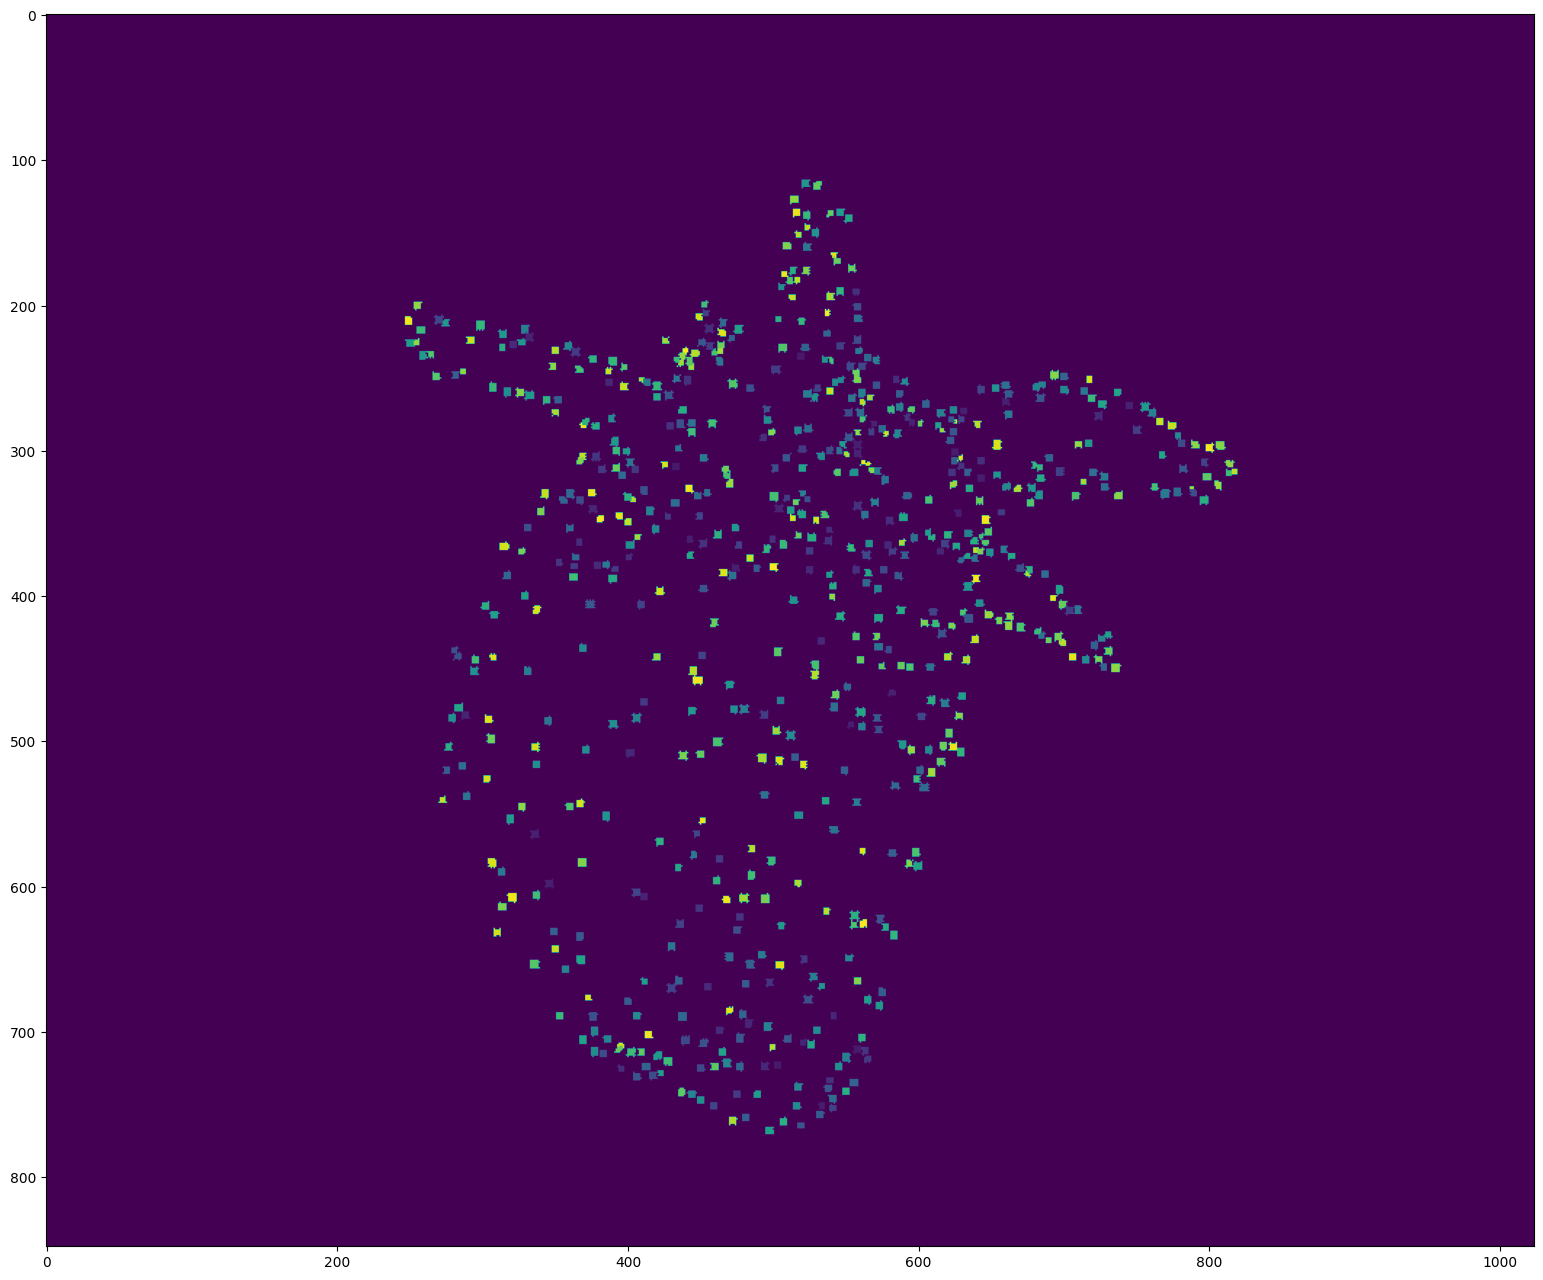

In [16]:
# Display the first detections

segmentation = detections_sequence[0].segmentation

if detections_sequence[0].dim == 3:  # 3D
    segmentation = segmentation[segmentation.shape[0] // 2]  # Show the segmentation in the middle of the stack

segmentation = segmentation.clone()
segmentation[segmentation!=0] += 50  # Improve visibility of firsts labels

plt.figure(figsize=(24, 16), dpi=100)
plt.imshow(segmentation)
plt.show()

In [17]:
# Display the detections with opencv
# Use w/x to move forward in time (or space to run/pause the video)
# Use b/n to move inside the stack (For 3D videos)
# Use v to switch on/off the display of the video
# Use d to switch detection display mode (None, mask, segmentation)

byotrack.visualize.InteractiveVisualizer(video, detections_sequence).run()